# Understanding GANs with CIFAR10
## Code adapted from https://github.com/phlippe/uvadlc_notebooks/tree/master/docs/tutorial_notebooks/tutorial10 and https://github.com/EricTay1997/AC-GAN_CIFAR10/blob/main/original.ipynb

### Boilerplate

In [15]:
## Standard libraries
import os
import numpy as np 
import random
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
## PyTorch Lightning
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import pytorch_lightning as pl
## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

/var/folders/2v/0s_wd0cd04g3xtcdpppg90980000gn/T/ipykernel_68163/195667682.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [4]:
device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
print("Using device", device)
DATASET_PATH = "../data"
CHECKPOINT_PATH = "./saved_models"
pl.seed_everything(42)

Seed set to 42


Using device mps


42

In [9]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip")]# (CHECKPOINT_PATH, "patches.zip")
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
# os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Unzipping file...


### Adversarial Attacks

In [7]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ./saved_models/hub/checkpoints/resnet34-b627a593.pth
100%|█████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:02<00:00, 37.3MB/s]


In [11]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)
    
def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

In [17]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels) 
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5
_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.10%
Top-5 error: 4.30%


In [18]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1 
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    
    plt.show()
    plt.close()

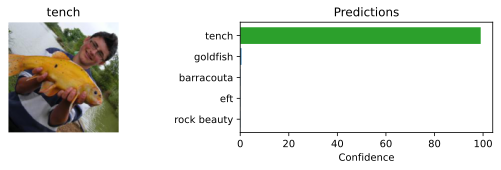

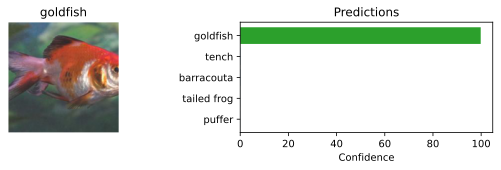

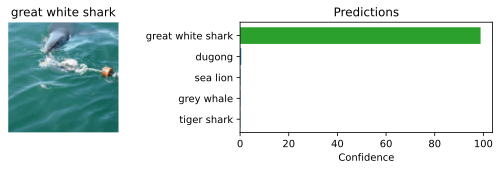

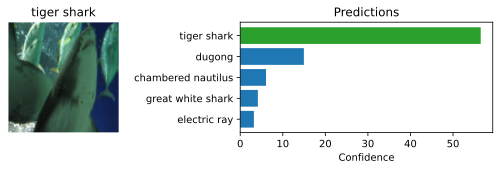

In [19]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

- Adversarial attacks are usually grouped into "white-box" and "black-box" attacks. 
- White-box attacks assume that we have access to the model parameter and can, for example, calculate the gradients with respect to the input (similar as in GANs).
- Black-box attacks on the other hand have the harder task of not having any knowledge about the network, and can only obtain predictions for an image, but no gradients or the like. 

#### FGSM

- The Fast Gradient Sign Method allows us to create an adversarial example by maximizing the loss:
- $\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_x L(\theta,x,y))$

In [29]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1)) # Cross-Entropy loss
    loss.sum().backward()
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

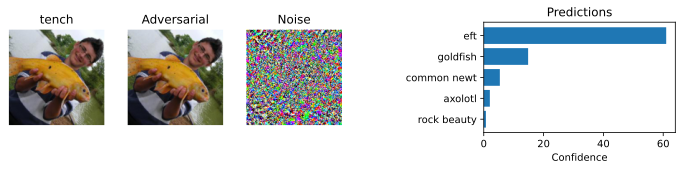

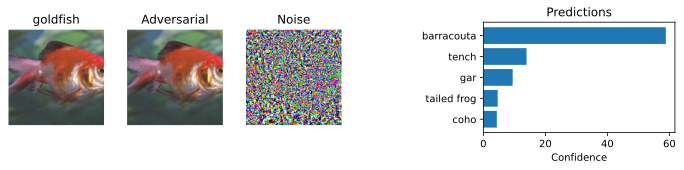

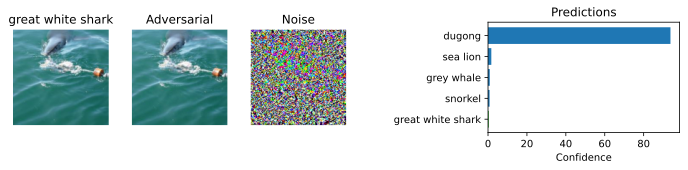

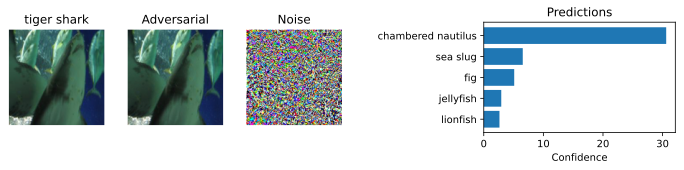

In [31]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.02)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))
    
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

In [33]:
_ = eval_model(data_loader, img_func=lambda x, y: fast_gradient_sign_method(pretrained_model, x, y, epsilon=0.02)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 93.56%
Top-5 error: 60.52%


#### Adversarial Patches

In [90]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [92]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [94]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4): 
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

In [96]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)
    
    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()
    
    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")
    
    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)
    
    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [98]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)
        
# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t 
                                   for t in patch_dict[cname][psize]["results"]] 
                           for psize in patch_dict[cname]} 
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [100]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)    
            
            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }
        
    return result_dict

In [ ]:
class_names = ['toaster', 'goldfish', 'school bus', 'lipstick', 'pineapple']
patch_sizes = [32, 48, 64]

patch_dict = get_patches(class_names, patch_sizes)

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for toaster and 32: {'acc': 0.46950000524520874, 'top5': 0.7289999723434448}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for toaster and 48: {'acc': 0.9150000214576721, 'top5': 0.9825000166893005}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for toaster and 64: {'acc': 0.9864729642868042, 'top5': 0.9989979863166809}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for goldfish and 32: {'acc': 0.7854999899864197, 'top5': 0.9185000061988831}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for goldfish and 48: {'acc': 0.9432730674743652, 'top5': 0.9904618263244629}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for goldfish and 64: {'acc': 0.9704999923706055, 'top5': 0.9975000023841858}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for school bus and 32: {'acc': 0.7900000214576721, 'top5': 0.9185000061988831}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for school bus and 48: {'acc': 0.9333667159080505, 'top5': 0.9899799823760986}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for school bus and 64: {'acc': 0.9869999885559082, 'top5': 0.9990000128746033}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for lipstick and 32: {'acc': 0.4423847794532776, 'top5': 0.7054108381271362}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for lipstick and 48: {'acc': 0.8794999718666077, 'top5': 0.9754999876022339}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for lipstick and 64: {'acc': 0.9662978053092957, 'top5': 0.9984909296035767}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for pineapple and 32: {'acc': 0.8015000224113464, 'top5': 0.9309999942779541}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for pineapple and 48: {'acc': 0.9463927745819092, 'top5': 0.9914829730987549}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for pineapple and 64: {'acc': 0.9884999990463257, 'top5': 1.0}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

In [ ]:
1+1

In [ ]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [ ]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

In [ ]:
show_table(top_1=True)

In [ ]:
show_table(top_1=False)

In [ ]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

In [ ]:
perform_patch_attack(patch_dict['goldfish'][32]['patch'])

In [ ]:
perform_patch_attack(patch_dict['school bus'][64]['patch'])

#### Transferability of white-box attacks

In [ ]:
transfer_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
transfer_model = transfer_model.to(device)

# No gradients needed for the network
transfer_model.eval()
for p in transfer_model.parameters():
    p.requires_grad = False

In [ ]:
class_name = 'pineapple'
patch_size = 64
print(f"Testing patch \"{class_name}\" of size {patch_size}x{patch_size}")

results = eval_patch(transfer_model, 
                     patch_dict[class_name][patch_size]["patch"], 
                     data_loader, 
                     target_class=label_names.index(class_name))

print(f"Top-1 fool accuracy: {(results[0] * 100.0):4.2f}%")
print(f"Top-5 fool accuracy: {(results[1] * 100.0):4.2f}%")

### GANs